## Select GPU

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

!nvidia-smi

## Import Required Libraries

In [78]:
import torch
import timeit
import os
import copy
import random
import numpy as np

from gene import Gene
from dataset import HippocampusDataset
from validation_utils import calibrate_batchnorm, dice_loss, dice_loss_categorical, dice_score, dice_score_categorical, combined_loss, feature_layer_loss, output_layer_loss, validate, calculate_net_size_from_3d_unet_config, iou_score, iou_score_categorical, dice_iou_combined, dice_iou_categorical_combined
from elastic_3d_unet import Elastic3DUNet

import os, random, math, torch, copy
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

## Load Settings

In [ ]:
import json

with open('config-3DUNet-HIPPO.json') as f:
    config = json.load(f)
    
init_config = config['initialization']
ofa_settings = config['ofa_settings']

config

## Initialize Dataloader and OFA Network

In [83]:
volume_ids = [d.split('.npy.gz')[0] for d in os.listdir('data/HIPPO-3D/volumes')]
random.Random(9).shuffle(volume_ids)

train_ratio = 0.8
partition_pivot = math.ceil(len(volume_ids) * train_ratio)

EPOCHS = 1
BATCH_SIZE = 16
SOFT_BATCH = 4

input_dim = 80


val_set = HippocampusDataset(volume_ids=random.Random(9).sample(volume_ids[partition_pivot:], 15), input_dim=input_dim)
val_generator = torch.utils.data.DataLoader(val_set, batch_size=2, num_workers=4, pin_memory=True)

test_set = HippocampusDataset(volume_ids=volume_ids[partition_pivot:], input_dim=input_dim)
test_generator = torch.utils.data.DataLoader(test_set, batch_size=2, num_workers=4, pin_memory=True)



In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Elastic Kernel
expanding_kernels=init_config['expanding_kernels']

# Elastic Depth
train_only_current_stage=init_config['train_only_current_stage']

# Elastic Width
keep_channel_order=init_config['keep_channel_order']

distill_knowledge=init_config['distill_knowledge']
# output_distill_knowledge=False

input_dim=init_config['input_dim']

output_n=init_config['output_n']
kernels=init_config['kernels']
max_depth=init_config['max_depth']

initial_out_channel=init_config['initial_out_channel']
sections=init_config['sections']

net = Elastic3DUNet(input_dim=input_dim, 
                    output_n=output_n, 
                    max_depth=max_depth, 
                    expanding_kernels=expanding_kernels,
                    train_only_current_stage=train_only_current_stage,
                    keep_channel_order=keep_channel_order,
                    kernels=kernels,
                    sections=sections,
                    initial_out_channel=initial_out_channel,
                    bn_track_running_stats=True).to(device)

net.load_my_state_dict(torch.load(init_config['pretrained_weights_dir']))

## Evaluation Function

In [105]:
def evaluate_net(net, test_generator, val_generator):
    copy_net = copy.deepcopy(net)
    print('Calibrating batchnorm...')
    calibrate_batchnorm(copy_net, val_generator)
    print('--- Done')
    avg_latency = []
    
    all_outputs = []
    all_labels = []
    
    all_scores = np.asarray([0])
    all_scores_categorical = np.zeros(net.output_n)

    with torch.no_grad():
        copy_net.eval()
        j = -1
        for X, y in tqdm(test_generator):
            j += 1
            
            target_dim = y.size()[2:]
            X, y = X.to(device), y.cpu().numpy()
            copy_net.enable_sampling_mode()
            start_time = timeit.default_timer()

            output = copy_net(X)
            output = F.interpolate(output, size=target_dim)
            
            output = output.cpu().numpy()

            avg_latency += [timeit.default_timer() - start_time]

            all_outputs = output
            all_labels = y
            all_X = X.cpu().numpy()

            all_scores_categorical = all_scores_categorical + np.sum(dice_score_categorical(output, y), axis=0)
            all_scores = all_scores + np.sum([dice_score(output[b], y[b]) for b in range(test_generator.batch_size)])

            if j == 0:
                param_size = copy_net.calculate_param_size() /1000 /1000
                feature_size = copy_net.calculate_feature_size() /1000 /1000

                _, flops_count = calculate_net_size_from_3d_unet_config(copy_net)

            copy_net.disable_sampling_mode()

    n_test_samples = len(test_generator.dataset.volume_ids)
    avg_categorical_score = all_scores_categorical / n_test_samples
    avg_score = all_scores[0] / n_test_samples
    avg_latency = np.mean(avg_latency, axis=0)

            
    return avg_latency, avg_categorical_score[0], avg_categorical_score[1], avg_score, param_size, feature_size, flops_count, all_outputs, all_labels, all_X

## Sample and Inference

Calibrating batchnorm...
--- Done


  0%|          | 0/26 [00:00<?, ?it/s]

Sampled Subnet Configurations:
sections_configuration: 7
depth_configuration: [1, 1, 1, 1, 1, 1, 1]
kernels_configuration: [3, 5, 3, 3, 5, 3, 5, 3]
width_configuration: [16, 32, 32, 128, 32, 16, 16, 2]
input_resolution: 80

avg_latency : 0.0754062500065909
avg_categorical_score_0 : 0.5918489316335092
avg_categorical_score_1 : 0.5252297612336966
avg_score : 0.5688426388386534
param_size : 0.936272
feature_size : 67.392
flops_count : 42.988800000000005

Sample inference:


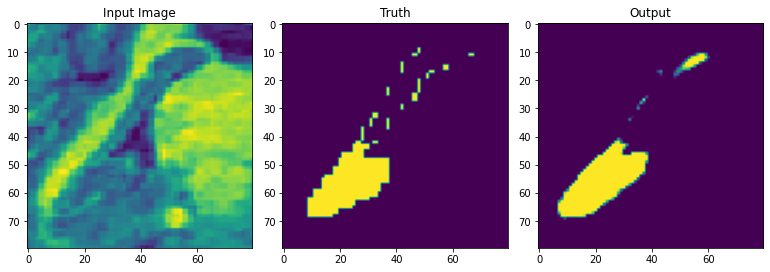

In [111]:
settings = {
    'resolutions': [48,64,80],
    'kernels': [3,5],
    'sections': [7],
    'max_depth': 1,
    'initial_channel': 8,
    'width_selection': [1,2],
    'output_n': 2
}

gene = Gene(settings=settings, properties={}, configurations={})
properties = gene.export_properties()
configurations = gene.export_configurations()
net.load_configuration(configurations)
test_generator.dataset.set_input_dim(randomize=True, permute_from=[net.input_resolution])
val_generator.dataset.set_input_dim(randomize=True, permute_from=[net.input_resolution])

metrics = evaluate_net(net, test_generator, val_generator)
columns = ['avg_latency', 'avg_categorical_score_0', 'avg_categorical_score_1', 'avg_score', 'param_size', 'feature_size', 'flops_count', 'all_outputs', 'all_labels']

print('Sampled Subnet Configurations:')
for k,v in configurations.items():
    print('{}: {}'.format(k,v))
print()
for i in range(len(metrics) - 3):
    print(columns[i], ':', metrics[i])

print()
print('Sample inference:')
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(10.8, 7.2))
axs[0].title.set_text('Input Image')
axs[1].title.set_text('Truth')
axs[2].title.set_text('Output')

axs[0].imshow(metrics[-1][0,0,40])
# plt.show()
axs[1].imshow(metrics[-2][0,0,40])
# plt.show()
axs[2].imshow(metrics[-3][0,0,40])
plt.show()